In [23]:
import numbers
import numpy as np
import cv2 as cv
import scipy
import scipy.special
import scipy.spatial
import scipy.stats
import scipy.stats.qmc
import scipy.ndimage
import shapely
import shapely.geometry
import matplotlib
import matplotlib.patches
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from matplotlib.path import Path
import docplex
import docplex.mp.model
import control
import control.matlab

import utility as util

ModuleNotFoundError: No module named 'docplex'

In [ ]:
def get_state_space_representation():
    """Get state-space representation of double integrator model."""
    # A, sys.A both have shape (4, 4)
    A = np.diag([1, 1], k=2)
    # B, sys.B both have shape (4, 2)
    B = np.concatenate((np.diag([0,0]), np.diag([1,1]),))
    # C has shape (2, 4)
    C = np.concatenate((np.diag([1,1]), np.diag([0,0]),), axis=1)
    # D has shape (2, 2)
    D = np.diag([0, 0])
    sys = control.matlab.c2d(control.matlab.ss(A, B, C, D), 0.5)
    A = np.array(sys.A)
    B = np.array(sys.B)
    return (A, B)

def make_global_params():
    """Get Global LCSS parameters used across all loops"""
    params = util.AttrDict()
    params.M_big = 1000
    params.A, params.B = get_state_space_representation()
    # number of state variables x, number of input variables u
    # nx = 4, nu = 2
    params.nx, params.nu = params.B.shape
    bbox_lon, bbox_lat = 4.5, 2.5
    params.diag = np.sqrt(bbox_lon**2 + bbox_lat**2) / 2.
    # Prediction parameters
    params.T = 8
    params.L = 4 # number of faces of obstacle sets

    # Closed for solution of control without obstacles
    A, B, T, nx, nu = params.A, params.B, params.T, params.nx, params.nu
    # C1 has shape (nx, T*nx)
    C1 = np.zeros((nx, T*nx,))
    # C2 has shape (nx*(T - 1), nx*(T-1)) as A has shape (nx, nx)
    C2 = np.kron(np.eye(T - 1), A)
    # C3 has shape (nx*(T - 1), nx)
    C3 = np.zeros(((T - 1)*nx, nx,))
    # C, Abar have shape (nx*T, nx*T)
    C = np.concatenate((C1, np.concatenate((C2, C3,), axis=1),), axis=0)
    Abar = np.eye(T * nx) - C
    # Bbar has shape (nx*T, nu*T) as B has shape (nx, nu)
    Bbar = np.kron(np.eye(T), B)
    # Gamma has shape (nx*(T + 1), nu*T) as Abar\Bbar has shape (nx*T, nu*T)
    Gamma = np.concatenate((np.zeros((nx, T*nu,)),
            np.linalg.solve(Abar, Bbar),))
    params.Abar = Abar
    params.Bbar = Bbar
    params.Gamma = Gamma

    params.N_traj = np.prod(params.K)

    # x0 : np.array
    #   Initial state
    x0 = np.array([p_0_x, p_0_y, v_0_x, v_0_y])
    A, T = params.A, params.T
    params.theta = None
    params.v_lim = None
    # States_free_init has shape (nx*(T+1))
    params.States_free_init = np.concatenate([
            np.linalg.matrix_power(A, t) @ x0 for t in range(T+1)])
    return params

def compute_velocity_constraints(param, v_x, v_y):
    """Velocity states have coupled constraints.
    Generate docplex constraints for velocity for double integrators.

    Street speed limit is 30 km/h == 8.33.. m/s"""
    v_lim = param.v_lim # is m/s
    theta = param.theta
    r = v_lim / 2
    v_1 = r
    v_2 = 0.75 * v_lim
    c1 = v_2*((v_x - r*np.cos(theta))*np.cos(theta) \
            + (v_y - r*np.sin(theta))*np.sin(theta))
    c2 = v_1*((v_y - r*np.sin(theta))*np.cos(theta) \
            - (v_x - r*np.cos(theta))*np.sin(theta))
    c3 = np.abs(v_1 * v_2)
    constraints = []
    constraints.extend([ z <= c3 for z in  c1 + c2 ])
    constraints.extend([ z <= c3 for z in -c1 + c2 ])
    constraints.extend([ z <= c3 for z in  c1 - c2 ])
    constraints.extend([ z <= c3 for z in -c1 - c2 ])
    return constraints

def compute_acceleration_constraints(param, u_x, u_y):
    """Accelaration control inputs have coupled constraints.
    Generate docplex constraints for velocity for double integrators.

    Present performance cars are capable of going from 0 to 60 mph in under 5 seconds.
    Reference:
    https://en.wikipedia.org/wiki/0_to_60_mph"""
    theta = param.theta
    r = -2.5
    a_1 = 7.5
    a_2 = 5.0
    c1 = a_2*((u_x - r*np.cos(theta))*np.cos(theta) \
            + (u_y - r*np.sin(theta))*np.sin(theta))
    c2 = a_1*((u_y - r*np.sin(theta))*np.cos(theta) \
            - (u_x - r*np.cos(theta))*np.sin(theta))
    c3 = np.abs(a_1 * a_2)
    constraints = []
    constraints.extend([ z <= c3 for z in  c1 + c2 ])
    constraints.extend([ z <= c3 for z in -c1 + c2 ])
    constraints.extend([ z <= c3 for z in  c1 - c2 ])
    constraints.extend([ z <= c3 for z in -c1 - c2 ])
    return constraints

(-1.0, 20.0)

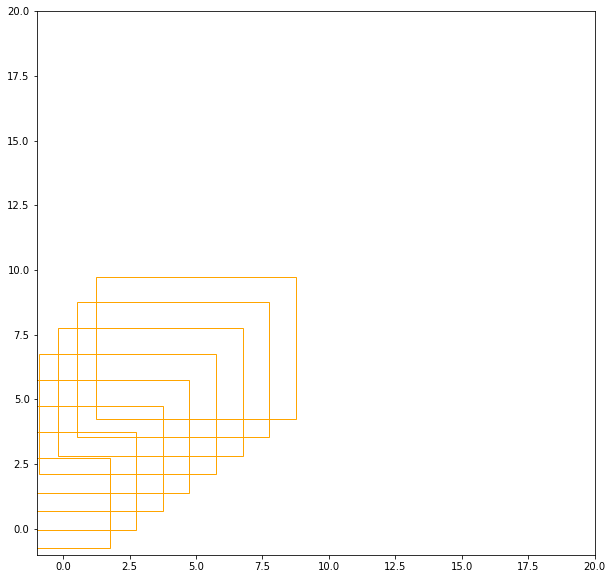

In [22]:
def kronecker_add_vectors(a, b):
    return a[None, :] + b[:, None]

def kronecker_mul_vectors(a, b):
    np.kron(a[None, :], b[:, None])

def get_vertices_from_centers_and_lws(centers, thetas, lws):
    C = np.cos(thetas)
    S = np.sin(thetas)
    rot11 = np.stack((-C,  S), axis=-1)
    rot12 = np.stack((-S, -C), axis=-1)
    rot21 = np.stack((-C, -S), axis=-1)
    rot22 = np.stack((-S,  C), axis=-1)
    rot31 = np.stack(( C, -S), axis=-1) 
    rot32 = np.stack(( S,  C), axis=-1)
    rot41 = np.stack(( C,  S), axis=-1)
    rot42 = np.stack(( S, -C), axis=-1)
    # Rot has shape (N, 8, 2)
    Rot = np.stack((rot11, rot12, rot21, rot22, rot31, rot32, rot41, rot42), axis=1)
    # disp has shape (N, 8)
    disp = 0.5 * np.einsum("...jk, ...k ->...j", Rot, lws)
    # centers has shape (N, 8)
    centers = np.tile(centers, (4,))
    return np.reshape(centers + disp, (-1,4,2))

fig, ax = plt.subplots(figsize=(10, 10))

T = 8
centers = kronecker_add_vectors(np.array([-1., 1.]), np.linspace(0., 6., T))
thetas = np.full(8, 0.)
lws = kronecker_add_vectors(np.array([4.5, 2.5]), np.linspace(1., 3., T))
vertex_set = get_vertices_from_centers_and_lws(centers, thetas, lws)

for vertices in vertex_set:
    patch = patches.Polygon(vertices, closed=True, color='orange', fc='none')
    ax.add_patch(patch)

ax.set_xlim([-1, 20])
ax.set_ylim([-1, 20])

In [ ]:


get_vertices_from_centers_and_lws(centers, thetas, lws)

init_poly = np.array([
    
])
patch = patches.Polygon(poly1, closed=True, color='r', fc='none')
plt.add_patch(patch)

In [ ]:


vertices = self.__compute_vertices(params, ovehicles)
A_union, b_union = self.__compute_overapproximations(vertices, params, ovehicles)

params = make_global_params()

K = None

"""Apply motion planning problem"""
model = docplex.mp.model.Model(name="proposed_problem")
L, T, Gamma, nu, nx = params.L, params.T, \
        params.Gamma, params.nu, params.nx
u = np.array(model.continuous_var_list(nu*T, lb=-np.inf, name='u'), dtype=object)
delta_tmp = model.binary_var_matrix(L*np.sum(K), T, name='delta')
delta = np.empty((L*np.sum(K), T,), dtype=object)
for k, v in delta_tmp.items():
    delta[k] = v

x_future = params.States_free_init + obj_matmul(Gamma, u)
# TODO: hardcoded value, need to specify better
big_M = 1000 # conservative upper-bound

x1 = x_future[nx::nx]
x2 = x_future[nx + 1::nx]
x3 = x_future[nx + 2::nx]
x4 = x_future[nx + 3::nx]
u1 = u[0::nu]
u2 = u[1::nu]

model.add_constraints(compute_velocity_constraints(x3, x4))
model.add_constraints(compute_acceleration_constraints(u1, u2))

X = np.stack([x1, x2], axis=1)
T, diag = params.T, params.diag
for ov_idx, ovehicle in enumerate(ovehicles):
    n_states = ovehicle.n_states
    sum_clu = np.sum(K[:ov_idx])
    for latent_idx in range(n_states):
        for t in range(T):
            A_obs = A_union[t][latent_idx][ov_idx]
            b_obs = b_union[t][latent_idx][ov_idx]
            indices = 4*(sum_clu + latent_idx) + np.arange(0,4)
            lhs = obj_matmul(A_obs, X[t]) + big_M*(1-delta[indices,t])
            rhs = b_obs + diag
            model.add_constraints([l >= r for (l,r) in zip(lhs, rhs)])
            model.add_constraint(np.sum(delta[indices, t]) >= 1)

# start from current vehicle position and minimize the objective
p_x, p_y = params.p_x, params.p_y
goal_x, goal_y = p_x + 20, p_y + 20
start = np.array([p_x, p_y])
goal = np.array([goal_x, goal_y])
cost = (x1[-1] - goal_x)**2 + (x2[-1] - goal_y)**2
model.minimize(cost)
# model.print_information()
# model.parameters.read.datacheck = 1
should_log_cplex = True
if should_log_cplex:
    model.parameters.mip.display = 5
    s = model.solve(log_output=True)
else:
    model.solve()
# model.print_solution()

u_star = np.array([ui.solution_value for ui in u])
cost = cost.solution_value
x1 = np.array([x1i.solution_value for x1i in x1])
x2 = np.array([x2i.solution_value for x2i in x2])
X_star = np.stack((x1, x2)).T
